In [1]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
class NinaproMaskedDataset(Dataset):
    def __init__(self, folders, window_len, step):
        self.windows = []
        self.window_len = window_len
        for folder in folders:
            files = glob(os.path.join(folder, '*.npy'))
            print(f"Found {len(files)} .npy files in {folder}", flush=True)
            for path in files:
                emg = np.load(path, mmap_mode='r')
                T, _ = emg.shape
                cnt = 0
                for st in range(0, T - window_len + 1, step):
                    self.windows.append((path, st))
                    cnt += 1
                print(f"  {os.path.basename(path)} → {cnt} windows", flush=True)
        print(f"Total windows: {len(self.windows)}\n", flush=True)

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        path, st = self.windows[idx]
        emg = np.load(path)                           # (T, C)
        seg = emg[st:st + self.window_len]             # (window_len, C)
        # Normalize per-channel
        seg = (seg - seg.mean(0)) / (seg.std(0) + 1e-6)
        return torch.from_numpy(seg.T.astype(np.float32))  # (C, T)

In [3]:
class MaskedEMGMAE(nn.Module):
    def __init__(self, in_ch, hidden_dim=128, mask_ratio=0.2):
        super().__init__()
        self.mask_ratio = mask_ratio
        # Encoder: 3-layer CNN
        self.encoder = nn.Sequential(
            nn.Conv1d(in_ch, 64, kernel_size=5, padding=2), nn.BatchNorm1d(64), nn.ReLU(True),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),  nn.BatchNorm1d(128), nn.ReLU(True),
            nn.Conv1d(128, hidden_dim, kernel_size=3, padding=1), nn.BatchNorm1d(hidden_dim), nn.ReLU(True),
        )
        # Decoder: mirror structure
        self.decoder = nn.Sequential(
            nn.Conv1d(hidden_dim, 128, kernel_size=3, padding=1), nn.BatchNorm1d(128), nn.ReLU(True),
            nn.Conv1d(128, 64, kernel_size=5, padding=2),  nn.BatchNorm1d(64),  nn.ReLU(True),
            nn.Conv1d(64, in_ch, kernel_size=5, padding=2),
        )

    def random_mask(self, x):
        B, C, T = x.shape
        num = int(T * self.mask_ratio)
        mask = torch.zeros((B, 1, T), dtype=torch.bool, device=x.device)
    
        # 一次性生成随机索引（CUDA 上）
        idx = torch.randint(0, T, (B, num), device=x.device)   # [B, num]
        mask.scatter_(2, idx.unsqueeze(1), True)               # 写 True 到掩码
        xm = x.masked_fill(mask.expand_as(x), 0.)
        return xm, mask

    def forward(self, x):
        xm, mask = self.random_mask(x)
        feat = self.encoder(xm)
        rec  = self.decoder(feat)
        return rec, x, mask

    def compute_loss(self, rec, x, mask):
        loss_mask   = F.mse_loss(rec[mask.expand_as(rec)],    x[mask.expand_as(x)])
        inv_mask    = ~mask.expand_as(rec)
        loss_unmask = F.mse_loss(rec[inv_mask], x[inv_mask])
        return loss_mask + 0.1 * loss_unmask

In [4]:
WINDOW_LEN    = 400
STEP          = 100
MASK_RATIO    = 0.2
BATCH_SIZE    = 2048
EPOCHS        = 10
LR            = 1e-3
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_WORKERS   = 4

In [9]:
VIS_FOLDER = ['data/vis_sample']
CKPT_PATH   = 'checkpoint/full_model.pth'

In [10]:
ds = NinaproMaskedDataset(VIS_FOLDER, window_len=WINDOW_LEN, step=STEP)
dl = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0)

Found 1 .npy files in data/vis_sample
  s1_0_emg.npy → 18247 windows
Total windows: 18247



Original shape: (12, 400), Reconstructed shape: (12, 400), Mask shape: (1, 400)


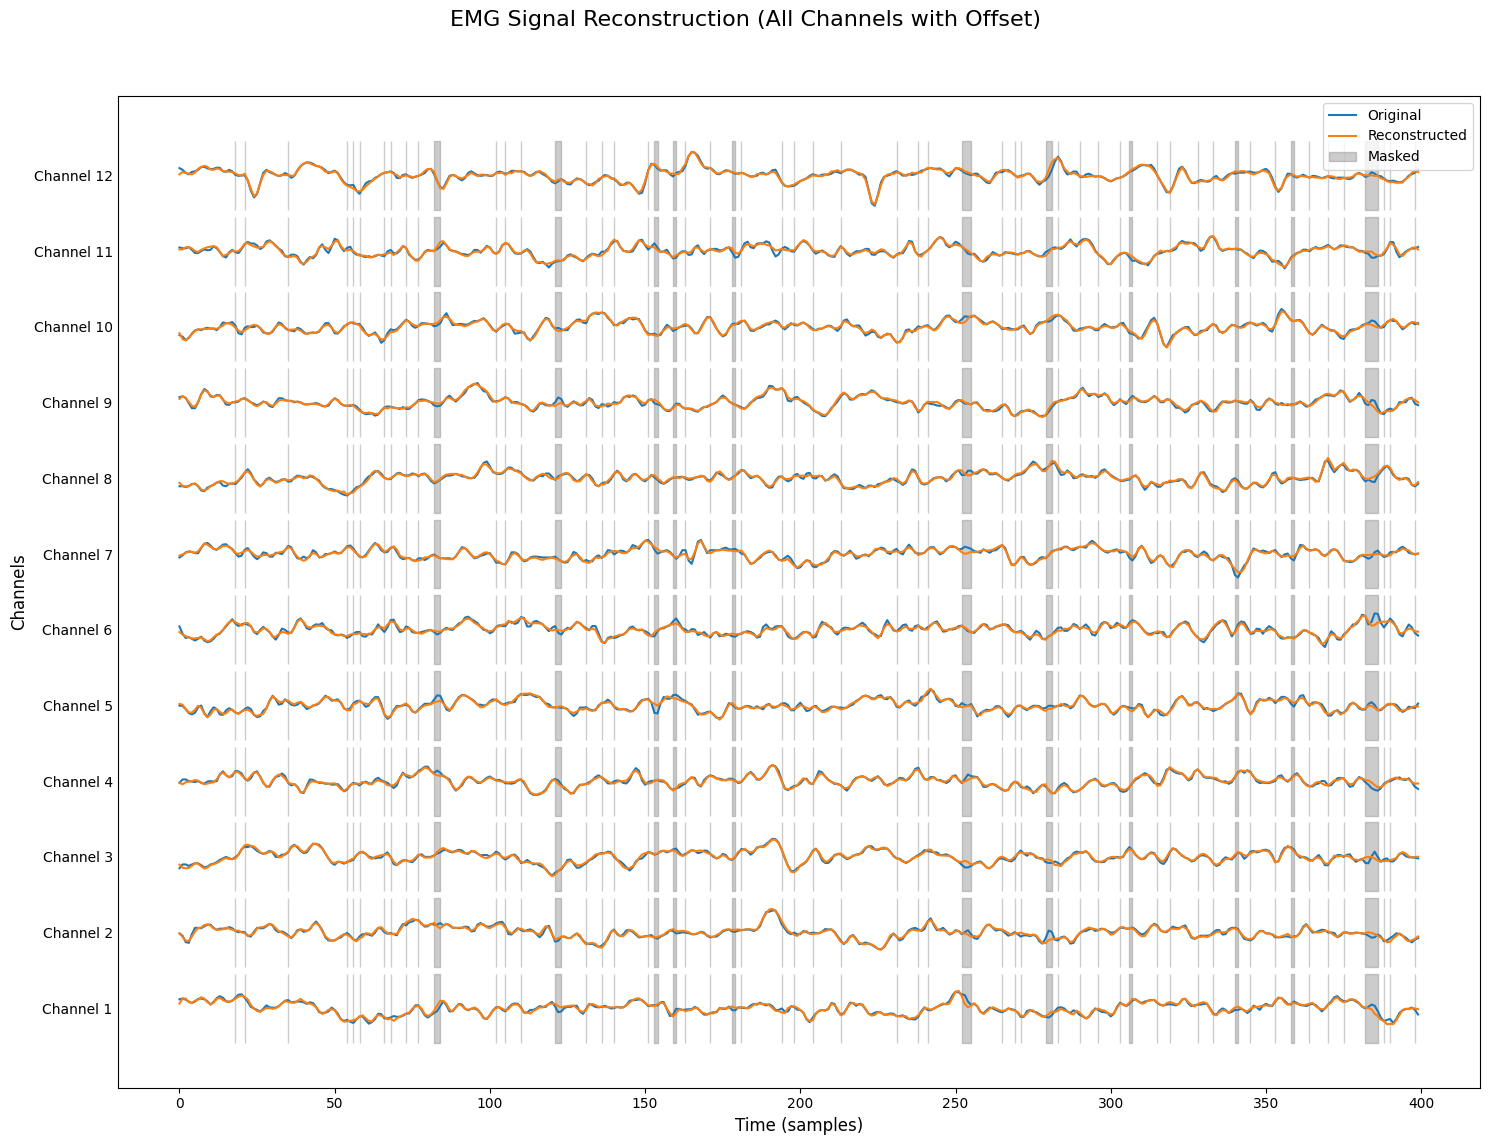

In [ ]:
batch = next(enumerate(dl))
feature = batch[1]
feature = feature.to(DEVICE)

in_ch = feature.shape[1]
model = MaskedEMGMAE(in_ch, hidden_dim=128, mask_ratio=MASK_RATIO).to(DEVICE)
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))
model.eval()
with torch.no_grad():
    reconstructed, original, mask = model(feature)
original = original.squeeze(0).cpu().numpy()
reconstructed = reconstructed.squeeze(0).cpu().numpy()
mask = mask.squeeze(0).cpu().numpy()
print(f"Original shape: {original.shape}, Reconstructed shape: {reconstructed.shape}, Mask shape: {mask.shape}")

num_channels = original.shape[0]

fig, ax = plt.subplots(figsize=(15, 12))
y_offset = np.abs(original).max() * 2.5
masked = mask[0]

for c in range(num_channels):
    offset = c * y_offset
    current_original = original[c] + offset
    current_reconstructed = reconstructed[c] + offset

    # Plot original and reconstructed signals
    ax.plot(np.arange(current_original.shape[0]), current_original, color='C0', linewidth=1.5, label='Original' if c == 0 else "")
    ax.plot(np.arange(current_reconstructed.shape[0]), current_reconstructed, color='C1', linewidth=1.5, label='Reconstructed' if c == 0 else "")
    
    # Use fill_between for the masked regions
    ax.fill_between(np.arange(len(masked)), offset - y_offset/2.2, offset + y_offset/2.2, where=masked, color='gray', alpha=0.4, label='Masked' if c == 0 else "")

# Customize the plot
ax.set_xlabel('Time (samples)', fontsize=12)
ax.set_ylabel('Channels', fontsize=12)

# Set y-ticks to be in the middle of each channel's plot
ax.set_yticks([c * y_offset for c in range(num_channels)])
ax.set_yticklabels([f'Channel {c+1}' for c in range(num_channels)])
ax.tick_params(axis='y', length=0) # Hide y-tick lines

ax.legend(loc='upper right')
plt.suptitle('EMG Signal Reconstruction (All Channels with Offset)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()